# Decoding Reward Prediction Errors with LaseNet

In this notebook we will:

1. **Simulate reward prediction errors (RPEs)** from a contextual bandit task using the `World` and `FeatureRL.Agent` classes library.
2. **Build a dataset** of trial-by-trial features and ground-truth RPEs.
3. **Use [LaseNet](https://github.com/ti55987/lasenet)** to train a neural decoder that reconstructs RPEs from behavioral features.

This notebook is designed to run locally. The only external dependency we assume you can install via the command line is the LaseNet repository (using `git clone`).


In [1]:
# Imports and setup
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure local libraries are on the path
sys.path.append(os.path.join(os.getcwd(), "libraries"))

from World import World
from FeatureRL import Agent as FRL

sns.set(style="whitegrid")
plt.style.use("default")

print("Environment ready.")

Environment ready.


## Step 1 – Simulate RPE data for many agents

We first generate a dataset of reward prediction errors using the existing `World` and `FeatureRL.Agent` classes.

On each trial for each agent we will record:

- **Features** (inputs to the decoder), e.g.:
  - One-hot encoding of the chosen stimulus features
  - Previous reward and previous RPE (optional, for richer context)
- **Target** (what we want to decode):
  - The agent’s internal **reward prediction error** `rpe_t = r_t − V_t` that we already compute inside `Agent.simulate_choice_task` and now expose as `results['rpe']`.

We will flatten all agents and trials into a single matrix `X` (features) and a vector `y_rpe` (RPEs).

In [2]:
def simulate_rpe_dataset(
    n_agents=100,
    n_trials=50,
    n_dims=2,
    n_feats_per_dim=3,
    world_h=0.0,
    world_p_high=0.8,
    world_p_low=0.2,
    outcome_value=1.0,
    agent_params=None,
):
    """Simulate many agents and build a dataset for RPE decoding.

    Returns
    -------
    X : np.ndarray, shape (N, D)
        Feature matrix (N = n_agents * n_trials).
    y_rpe : np.ndarray, shape (N, 1)
        Reward prediction errors per trial.
    meta : pd.DataFrame
        Metadata with columns ['agent_id', 'trial', 'reward', 'target_feature'].
    """
    if agent_params is None:
        agent_params = {
            "learning_rate": 0.2,
            "decay_rate": 0.0,
            "beta_value_choice": 5.0,
            "beta_value_gaze": 0.0,
            "beta_center_dim": 0.0,
            "beta_center_feat": 0.0,
            "w_init": 0.0,
            "decay_target": 0.0,
            "precision": 0.0,
            "phi": 0.5,  # neutral attention by default
        }

    X_rows = []
    y_rpe = []
    meta_rows = []

    for agent_id in range(n_agents):
        # New world and agent per agent (can also reuse world if you prefer)
        world = World(n_dims, n_feats_per_dim, world_h, world_p_high, world_p_low, outcome_value)
        agent = FRL(world, agent_params)

        results = agent.simulate_choice_task(world, n_trials=n_trials)

        rpe = results["rpe"]               # shape (n_trials,)
        choices = results["choices"]       # shape (n_trials, n_dims), expanded feature codes
        outcomes = results["outcomes"]     # shape (n_trials,)

        for t in range(n_trials):
            choice = choices[t]            # e.g. array of feature indices per dimension
            # One-hot encode chosen features over the full feature space
            feat_vec = np.zeros(world.n_feats, dtype=np.float32)
            feat_vec[choice - 1] = 1.0

            prev_reward = outcomes[t - 1] if t > 0 else 0.0
            prev_rpe = rpe[t - 1] if t > 0 else 0.0

            # Simple feature vector: [one-hot(choice features), prev_reward, prev_rpe]
            x = np.concatenate([feat_vec, np.array([prev_reward, prev_rpe], dtype=np.float32)])
            X_rows.append(x)
            y_rpe.append(rpe[t])
            meta_rows.append(
                {
                    "agent_id": agent_id,
                    "trial": t,
                    "reward": float(outcomes[t]),
                    "target_feature": int(results["target"]),  # last target; OK for stationary h=0
                }
            )

    X = np.vstack(X_rows).astype(np.float32)
    y_rpe = np.asarray(y_rpe, dtype=np.float32).reshape(-1, 1)
    meta = pd.DataFrame(meta_rows)

    print(f"Simulated dataset: X shape = {X.shape}, y_rpe shape = {y_rpe.shape}")
    return X, y_rpe, meta

In [3]:
# Simulate a dataset
n_agents = 100
n_trials = 50

X, y_rpe, meta = simulate_rpe_dataset(
    n_agents=n_agents,
    n_trials=n_trials,
    n_dims=2,
    n_feats_per_dim=3,
    world_h=0.0,        
    world_p_high=0.8,
    world_p_low=0.2,
)

meta.head()

Simulated dataset: X shape = (5000, 8), y_rpe shape = (5000, 1)


,agent_id,trial,reward,target_feature
0,0,0,0.0,6
1,0,1,0.0,6
2,0,2,0.0,6
3,0,3,1.0,6
4,0,4,0.0,6


In [6]:
# Install required dependencies (run this cell if you get import errors)
%pip install tensorflow scikit-learn -q

print("Dependencies installed.")


[notice] A new release of pip is available: 23.3.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dependencies installed.


## Step 2 – Clone and import LaseNet

We now clone the [LaseNet](https://github.com/ti55987/lasenet) repository locally and add it to the Python path.

> **Note:** This cell requires internet access the first time you run it. If you already have the repository locally, you can skip the `git clone` line and just ensure the `lasenet` folder is on your `PYTHONPATH`. 

In [5]:
# Clone LaseNet (run once). Comment this out if you already have the repo.
!git clone https://github.com/ti55987/lasenet.git || echo "lasenet repo already exists"

# Add LaseNet to the Python path
lasenet_root = os.path.join(os.getcwd(), "lasenet")
sys.path.append(lasenet_root)
sys.path.append(os.path.join(lasenet_root, "training"))
sys.path.append(os.path.join(lasenet_root, "utils"))

from training.models import create_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

print("LaseNet imported.")

fatal: destination path 'lasenet' already exists and is not an empty directory.
lasenet repo already exists
LaseNet imported.


## Step 3 – Build and train a LaseNet decoder for RPE

We treat the RPE as a one-dimensional continuous latent variable.

We will:

1. Split our simulated dataset into train/validation sets.
2. Build a LaseNet model with a single continuous output.
3. Train it to minimize mean squared error between predicted and true RPEs.

In [7]:
# Reshape data into sequences: (n_agents, n_trials, features)
# LaseNet expects 3D input: (batch, time_steps, features)
n_agents = meta['agent_id'].nunique()
n_trials = meta['trial'].nunique()
feature_dim = X.shape[1]

# Reshape X from (n_agents * n_trials, features) to (n_agents, n_trials, features)
X_seq = X.reshape(n_agents, n_trials, feature_dim)
y_rpe_seq = y_rpe.reshape(n_agents, n_trials, 1)

print(f"Reshaped X: {X_seq.shape}, Reshaped y_rpe: {y_rpe_seq.shape}")

# Train/validation split (split by agents, not individual trials)
agent_ids = np.arange(n_agents)
train_agent_ids, val_agent_ids = train_test_split(
    agent_ids, test_size=0.2, random_state=42
)

X_train = X_seq[train_agent_ids]
X_val = X_seq[val_agent_ids]
y_train = y_rpe_seq[train_agent_ids]
y_val = y_rpe_seq[val_agent_ids]

print(f"Train: X shape = {X_train.shape}, y shape = {y_train.shape}")
print(f"Val: X shape = {X_val.shape}, y shape = {y_val.shape}")

# Define model hyperparameters (you can experiment with these)
continuous_output_dim = 1
discrete_output_dim = 0

units = 128
dropout = 0.1
dropout1 = 0.05
dropout2 = 0.05
learning_rate = 3e-4

lasenet = create_model(
    feature_dim,
    discrete_output_dim,
    continuous_output_dim,
    units,
    dropout,
    dropout1,
    dropout2,
)

# When there's only one output, pass target directly (not as dict) and use string loss
lasenet.compile(
    loss="mse",
    optimizer=Adam(learning_rate=learning_rate),
)

print(lasenet.summary())

# Train the decoder on RPEs
# With single output, pass y directly (not as dictionary)
history = lasenet.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=128,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)],
    verbose=1,
)

Reshaped X: (100, 50, 8), Reshaped y_rpe: (100, 50, 1)
Train: X shape = (80, 50, 8), y shape = (80, 50, 1)
Val: X shape = (20, 50, 8), y shape = (20, 50, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ [(None, None, 256),    │       105,984 │
│                                 │ (None, 128), (None,    │               │
│                                 │ 128)]                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ continuous_latent (Dense)       │ (None, None, 1)        │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,545 (486.50 KB)

 Trainable params: 124,545 (486.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40


2026-01-28 15:55:15.727388: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2896 - val_loss: 0.2696
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.2691 - val_loss: 0.2511
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2513 - val_loss: 0.2377
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2387 - val_loss: 0.2278
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2284 - val_loss: 0.2205
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2207 - val_loss: 0.2154
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2158 - val_loss: 0.2119
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.2117 - val_loss: 0.2093
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2087 - val_loss: 0.2075
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.2072 - val_loss: 0.2060
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2056 - val_loss: 0.2048
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.2042 - val_loss: 0.2038
Epo

## Step 4 – Evaluate decoder performance

Visualize how well the LaseNet decoder reconstructs RPEs from behavioral features.

2026-01-28 15:55:30.365551: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Correlation: r = 0.662 (p = 3.81e-127)
R² score: 0.335
Best agent: 10 (r = 0.742)
Worst agent: 90 (r = 0.535)


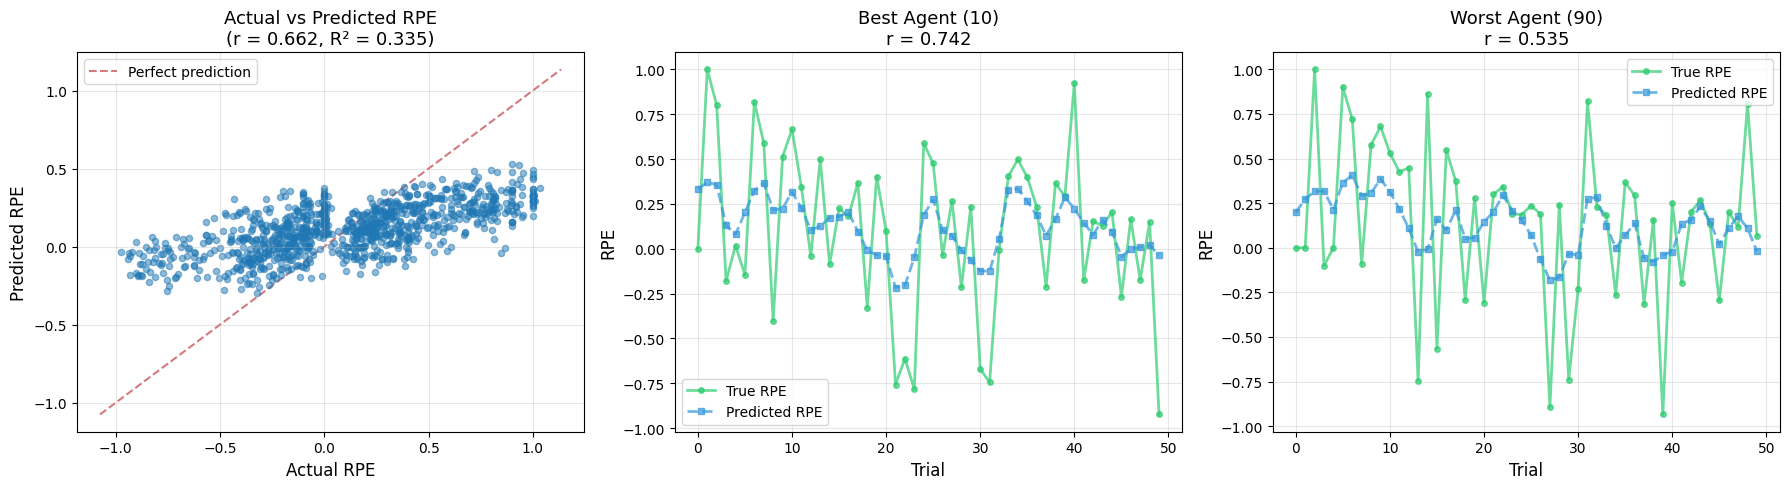

In [8]:
# Get predictions on validation set
y_pred = lasenet.predict(X_val, verbose=0)

# Flatten for correlation/scatter plots
y_true_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

# Compute correlation and R²
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

corr, p_val = pearsonr(y_true_flat, y_pred_flat)
r2 = r2_score(y_true_flat, y_pred_flat)

print(f"Correlation: r = {corr:.3f} (p = {p_val:.2e})")
print(f"R² score: {r2:.3f}")

# Compute per-agent correlations to find best and worst
agent_corrs = []
for i in range(len(val_agent_ids)):
    agent_true = y_val[i].flatten()
    agent_pred = y_pred[i].flatten()
    agent_corr, _ = pearsonr(agent_true, agent_pred)
    agent_corrs.append(agent_corr)

agent_corrs = np.array(agent_corrs)
best_idx = np.argmax(agent_corrs)
worst_idx = np.argmin(agent_corrs)
best_agent_id = val_agent_ids[best_idx]
worst_agent_id = val_agent_ids[worst_idx]

print(f"Best agent: {best_agent_id} (r = {agent_corrs[best_idx]:.3f})")
print(f"Worst agent: {worst_agent_id} (r = {agent_corrs[worst_idx]:.3f})")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Scatter plot of actual vs predicted (all trials)
ax1 = axes[0]
ax1.scatter(y_true_flat, y_pred_flat, alpha=0.5, s=20)
# Add diagonal line
lims = [
    np.min([ax1.get_xlim()[0], ax1.get_ylim()[0]]),
    np.max([ax1.get_xlim()[1], ax1.get_ylim()[1]]),
]
ax1.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect prediction')
ax1.set_xlabel('Actual RPE', fontsize=12)
ax1.set_ylabel('Predicted RPE', fontsize=12)
ax1.set_title(f'Actual vs Predicted RPE\n(r = {corr:.3f}, R² = {r2:.3f})', fontsize=13)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Panel 2: Best performing agent
ax2 = axes[1]
best_true = y_val[best_idx].flatten()
best_pred = y_pred[best_idx].flatten()
trials = np.arange(len(best_true))

ax2.plot(trials, best_true, 'o-', alpha=0.7, label='True RPE', 
         linewidth=2, markersize=4, color='#2ecc71')
ax2.plot(trials, best_pred, 's--', alpha=0.7, label='Predicted RPE', 
         linewidth=2, markersize=4, color='#3498db')
ax2.set_xlabel('Trial', fontsize=12)
ax2.set_ylabel('RPE', fontsize=12)
ax2.set_title(f'Best Agent ({best_agent_id})\nr = {agent_corrs[best_idx]:.3f}', fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Panel 3: Worst performing agent
ax3 = axes[2]
worst_true = y_val[worst_idx].flatten()
worst_pred = y_pred[worst_idx].flatten()

ax3.plot(trials, worst_true, 'o-', alpha=0.7, label='True RPE', 
         linewidth=2, markersize=4, color='#2ecc71')
ax3.plot(trials, worst_pred, 's--', alpha=0.7, label='Predicted RPE', 
         linewidth=2, markersize=4, color='#3498db')
ax3.set_xlabel('Trial', fontsize=12)
ax3.set_ylabel('RPE', fontsize=12)
ax3.set_title(f'Worst Agent ({worst_agent_id})\nr = {agent_corrs[worst_idx]:.3f}', fontsize=13)
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exercise (optional) – Exploring distribution shift: How does training distribution affect decoding?

In real-world applications, we often train decoders on data from one experimental condition and then apply them to new conditions. How robust is our decoder to changes in task structure? Choose one of the below to explore this question. Write down a hypothesis about how the distribution shift you chose may change decoder performance.

**Distribution shifts:**

1. **Task difficulty mismatch**: What happens when you train on an "easy" task (e.g., p_high=0.9, p_low=0.1) and test on a "hard" task (e.g., p_high=0.6, p_low=0.4), or vice versa? 
   - Hypothesis: *YOUR ANSWER HERE*

2. **Non-stationary environments**: What happens when you train on a stationary environment (h=0) but test on a non-stationary one (h>0), where the target feature changes over time?
   - Hypothesis: *YOUR ANSWER HERE*

**Experimental design:**

- Create training sets with different task parameters (p_high, p_low, h)
- Train separate decoders on each distribution
- Test each decoder on both its training distribution and other distributions
- Compare cross-distribution performance to within-distribution performance
- Visualize how decoding accuracy degrades as the test distribution diverges from training

**Implications:**

This exercise explores how neural decoders trained under one experimental condition behave when applied to different conditions. Discuss what this reveals about generalization and distribution shift for this particular problem. What can we learn from the decoder’s performance -- whether it generalizes well or poorly -- about our experimental design, the development of decoding methods, and how decoding results should be interpreted?